To generate a scattering curve for the Acrylite Satinice material:

Use Thor data describing ground glass.  The scattering distribution is, perhaps, the right shape,
  but the wrong width.
  
I fit the Thor data with the following function:

$
y = \left(\epsilon - 1\right) \cdot
cos\left(\theta\right)
\left(
A_1  \mathcal{N}\left(\mu,\,\sigma_1^{2}\right)
+ A_2  \mathcal{N}\left(\mu,\,\sigma_2^{2}\right) + A_3
\right)
$

Then I adjusted the $\sigma$ terms to make the width at $y=0.5$ fit the 20 degree specification.  Note this
measurement is expressed in terms of _incident_ intensity, not the maximum _transmitted_ intensity, which is why
the aborption multiplier is in there.  That yielded the following:
  
$$
\begin{align}
\epsilon &= 0.16 \quad (absorption)\\
\mu &= 0.0 \\
A_1 &= 0.75 \\
\sigma_1 &= 18.5^\circ \\
A_2 &= 0.25 \\
\sigma_2 &= 37^\circ \\
A_3 &= 0.008 \\
\end{align}
$$

So now figure out how to operate on this data using cupy.


In [1]:
# first make the pdf that drives the whole thing
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import norm
bins = 256
theta_rad = np.linspace(0, np.pi/2, bins)
epsilon = 0.16
mu = 0
a_1 = 0.75
sigma_1_deg = 18.5
a_2 = 0.25
sigma_2_deg = 37
a_3 = 0.008
degrees = theta_rad * 180 / np.pi
sigma_1_rad = sigma_1_deg * np.pi / 180
sigma_2_rad = sigma_2_deg * np.pi / 180
a_1_actually = sigma_1_rad * np.sqrt(2 * np.pi) * a_1
a_2_actually = sigma_2_rad * np.sqrt(2 * np.pi) * a_2

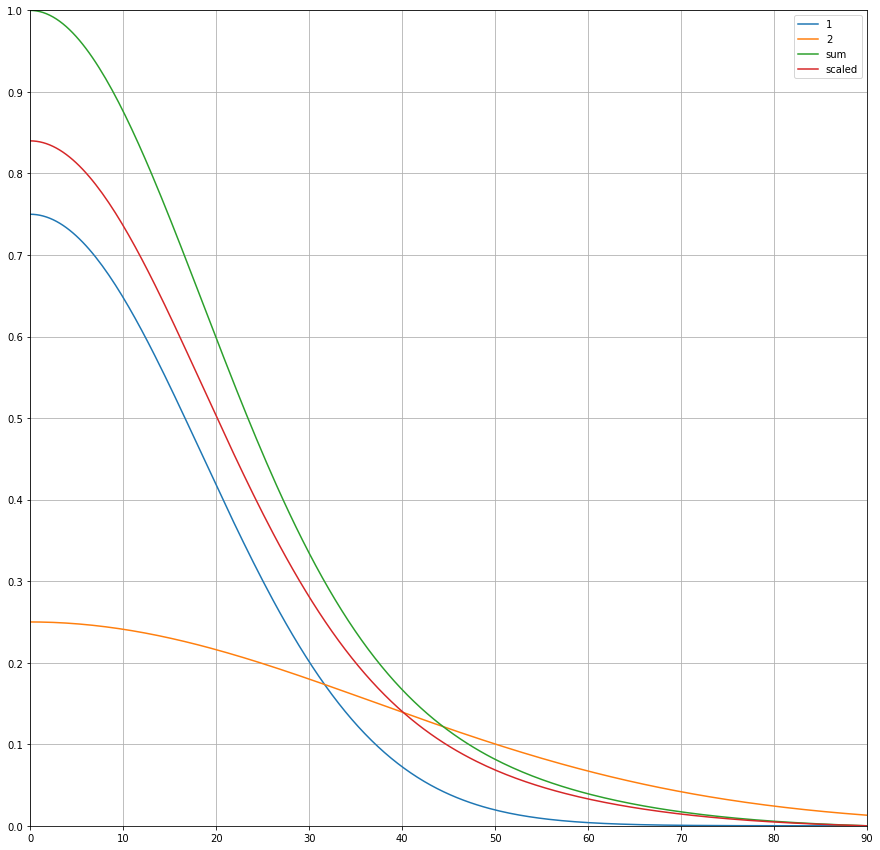

In [2]:
(fig,ax)=plt.subplots(figsize=[15,15])
ax.xaxis.set_major_locator(ticker.LinearLocator(10))
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_xlim(0,90)
ax.set_ylim(0,1)
plt.grid(True)

gaussian_1 = cp.array(a_1_actually * norm.pdf(theta_rad, scale = sigma_1_rad))
gaussian_2 = cp.array(a_2_actually * norm.pdf(theta_rad, scale = sigma_2_rad))
cp_theta_rad = cp.array(theta_rad)

gaussian_sum = ((gaussian_1 +  gaussian_2) * (1-a_3) + a_3) * cp.cos(cp_theta_rad)
scaled = gaussian_sum*(1-epsilon) # scale to *incident* intensity
plt.plot(degrees, gaussian_1.get(), label="1")
plt.plot(degrees, gaussian_2.get(), label="2")
plt.plot(degrees, gaussian_sum.get(), label="sum")
plt.plot(degrees, scaled.get(), label="scaled")
plt.legend()
plt.show()
# so "scaled" is the pdf i want.


In [3]:
# generate samples

def generate_rand_from_pdf(size, pdf: cp.ndarray, x_grid):
    cdf = cp.cumsum(pdf)
#    cdf = pdf.cumsum()
    cdf = cdf / cdf[-1]
    values = cp.random.rand(size) # [0,1)
    value_bins = cp.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf

size = 10000000
# "scaled" and "gaussian sum" are the same to a factor; the cdf is normalized anyway so it doesn't matter
samples = generate_rand_from_pdf(size, gaussian_sum, cp_theta_rad)
alive = cp.random.rand(size) > epsilon
print(alive)

[ True  True  True ...  True  True  True]


sum of output 0.8397837


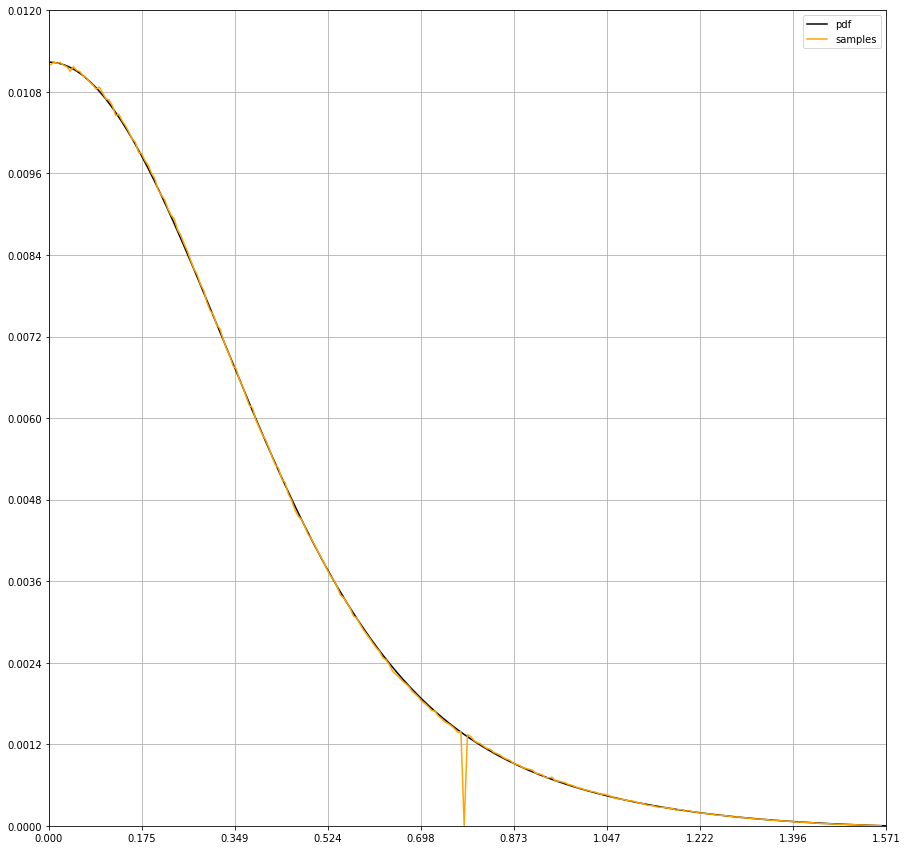

In [4]:
# plot the result

(fig,ax)=plt.subplots(figsize=[15,15])
plt.plot(theta_rad, scaled.get()/gaussian_sum.get().sum(), '-', label='pdf', color='black', snap=False)

counts, bin_edges = cp.histogram(samples, bins, weights=alive)
weights =  counts.get() / size
print(f"sum of output {np.sum(weights)}")
plt.plot((bin_edges.get()[:-1]+ bin_edges.get()[1:])/2, weights,
         color='orange', label='samples', snap = False)
ax.xaxis.set_major_locator(ticker.LinearLocator(10))
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_xlim(0,np.pi/2)
ax.set_ylim(0,0.012)
plt.grid(True)
plt.legend()
plt.show()

incident 20000000


/home/joel/.local/lib/python3.8/site-packages/cupyx/jit/_interface.py:161: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


count alive internal 18770310
intensity internal 0.93852
count alive external 16974369
intensity external 0.84872


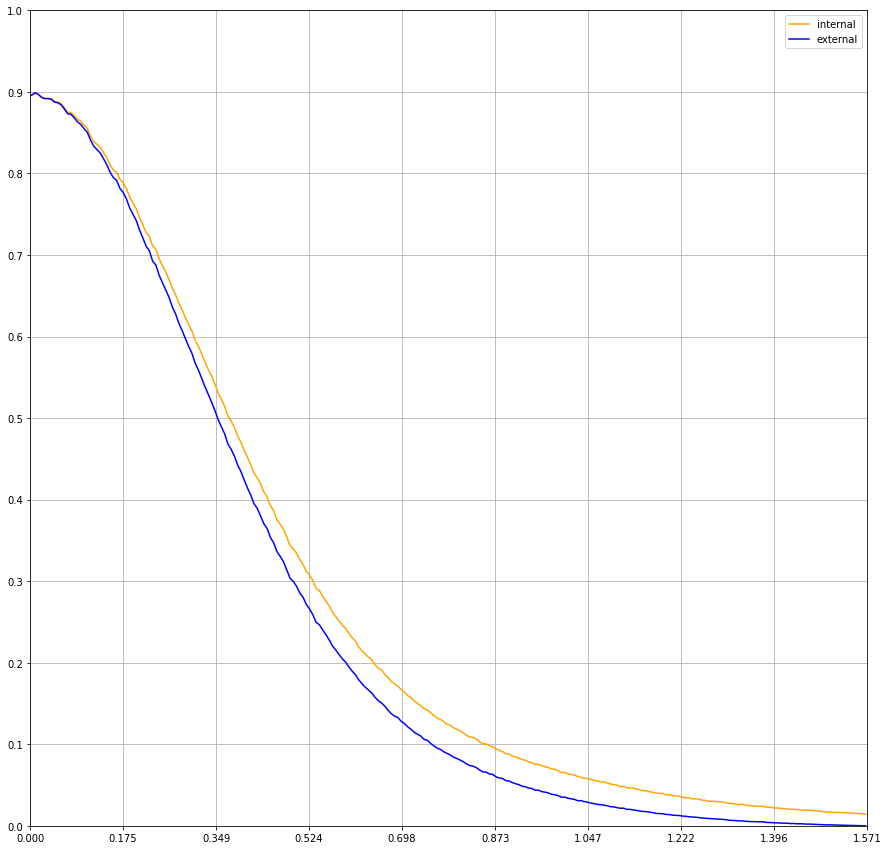

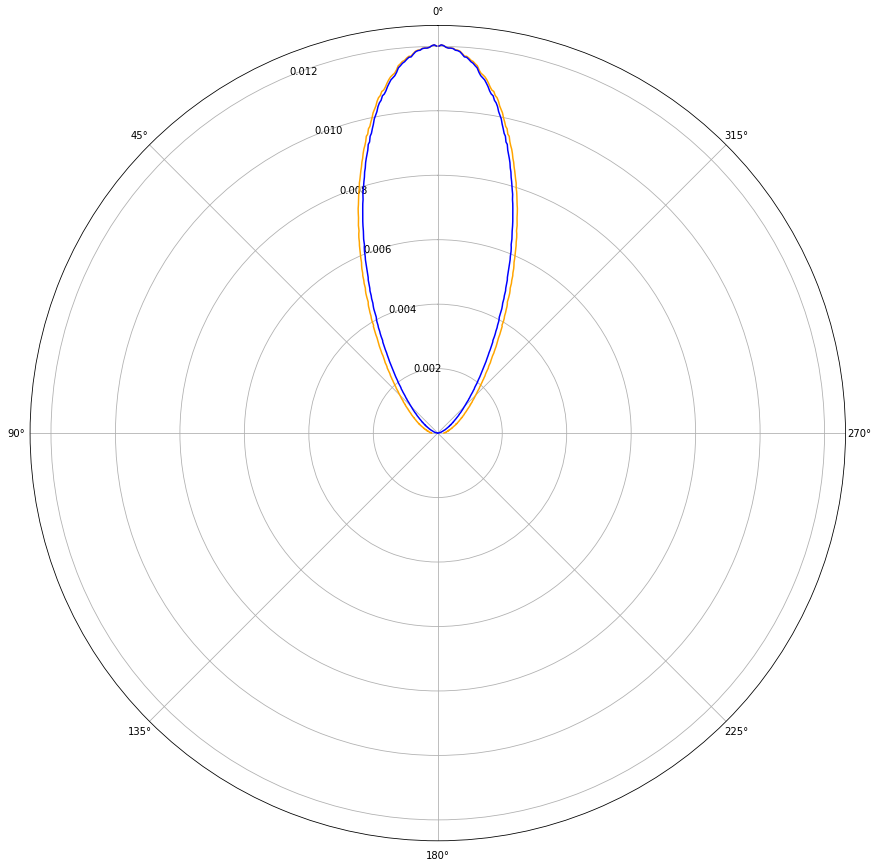

In [5]:
# try the library version
import scattering

scat = scattering.AcryliteScattering()
size = 20000000
print(f"incident {size}")

#epsilon = 0.16
epsilon = 0.0614 # yields 16% after cos is applied below
samples = scat.get_scattering_theta(size)

# accounts for internal absorption
alive = cp.random.rand(size) > epsilon
print(f"count alive internal {cp.sum(alive)}")
h, b = cp.histogram(samples, bins, weights=alive)
h =  h / size
print(f"intensity internal {np.sum(h):.5f}")

# accounts for internal reflection at the exit surface
alive = cp.logical_and(alive, cp.random.rand(size) < cp.cos(samples))  # <== do not use cosine
print(f"count alive external {cp.sum(alive)}")

h2, b2 = cp.histogram(samples, bins, weights=alive)
h2 =  h2 / size
print(f"intensity external {np.sum(h2):.5f}")

(fig,ax)=plt.subplots(figsize=[15,15])
scaling = 0.0134 # put the max at 0.84 to see the FWHM
plt.plot((b.get()[:-1]+ b.get()[1:])/2, h.get() / scaling, color='orange', label='internal', snap = False)
plt.plot((b2.get()[:-1]+ b2.get()[1:])/2, h2.get() / scaling, color='blue', label='external', snap = False)

ax.xaxis.set_major_locator(ticker.LinearLocator(10))
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_xlim(0,np.pi/2)
#ax.set_ylim(0,0.012)
ax.set_ylim(0,1)
plt.grid(True)
plt.legend()
plt.show()

fig = plt.figure(figsize=[15,15])
axes = plt.subplot(projection="polar")
axes.set_theta_zero_location("N")
axes.plot((b.get()[:-1]+ b.get()[1:])/2, h.get(), color="orange", snap=False)
axes.plot(-(b.get()[:-1]+ b.get()[1:])/2, h.get(), color="orange", snap=False)
axes.plot((b2.get()[:-1]+ b2.get()[1:])/2, h2.get(), color="blue", snap=False)
axes.plot(-(b2.get()[:-1]+ b2.get()[1:])/2, h2.get(), color="blue", snap=False)


photon batch energy joules: 1.790e-04
photon batch power watts: 1.790e-01
emitter area m^2: 0.000e+00
batch radiosity w/m^2: inf
[1. 1. 1. ... 1. 1. 1.]
[0.96182567 0.92090553 0.98408633 ... 0.8369891  0.55236495 0.99315864]
[0.27719927 0.40039903 0.17863959 ... 0.5790386  0.9855977  0.11703996]
[False  True  True ... False False  True]


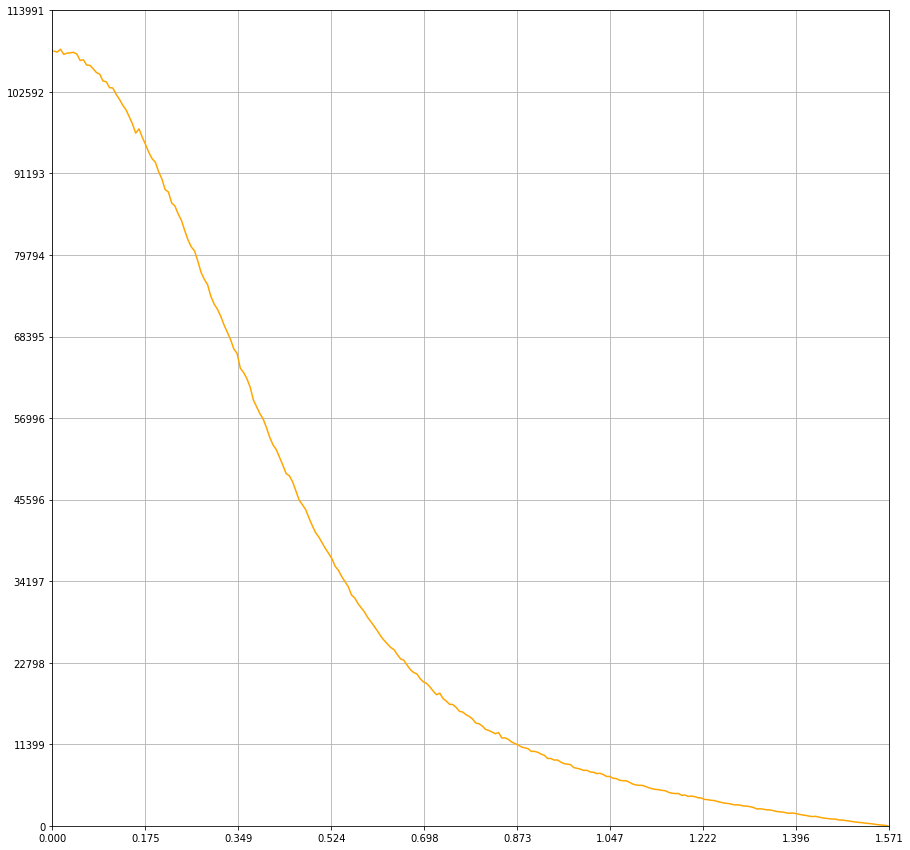

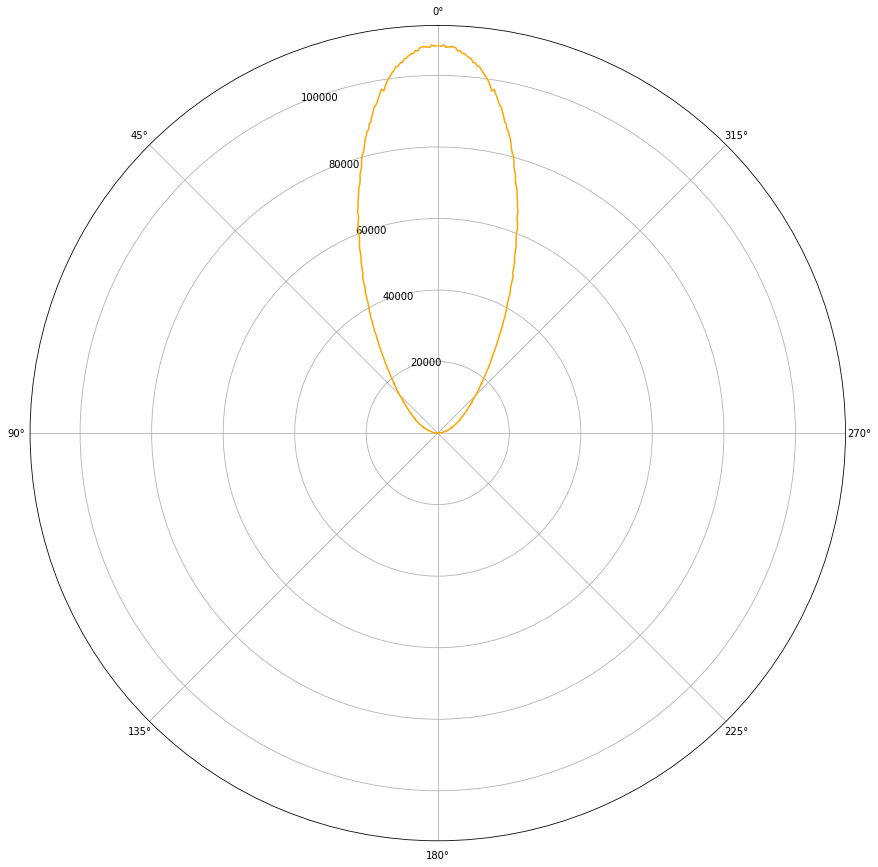

In [9]:
# try the Diffuser code
import optics_cuda
bundles = 10000000
source_wavelength_nm = 555
source_photons_per_bundle = 5e7
duration_s = 0.001
source = optics_cuda.PencilSource(source_wavelength_nm, source_photons_per_bundle, duration_s)
photons = source.make_photons(bundles)
photons.debug(0)
print(photons.ez_z)
diffuser = optics_cuda.AcryliteDiffuser()
diffuser.diffuse(photons)
print(photons.ez_z)

theta = cp.arccos(photons.ez_z)
print(theta)
print(photons.alive)
h, b = cp.histogram(theta, bins, weights=photons.alive)

(fig,ax)=plt.subplots(figsize=[15,15])
plt.plot((b.get()[:-1]+ b.get()[1:])/2, h.get(), color='orange', snap = False)

ax.xaxis.set_major_locator(ticker.LinearLocator(10))
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_xlim(0,np.pi/2)
#ax.set_ylim(0,0.012)
ax.set_ylim(0,)
plt.grid(True)

plt.show()

fig = plt.figure(figsize=[15,15])
axes = plt.subplot(projection="polar")
axes.set_theta_zero_location("N")
axes.set_theta_zero_location("N")
axes.plot((b.get()[:-1]+ b.get()[1:])/2, h.get(), color="orange", snap=False)
axes.plot(-(b.get()[:-1]+ b.get()[1:])/2, h.get(), color="orange", snap=False)
plt.show()

0.03936128770567188


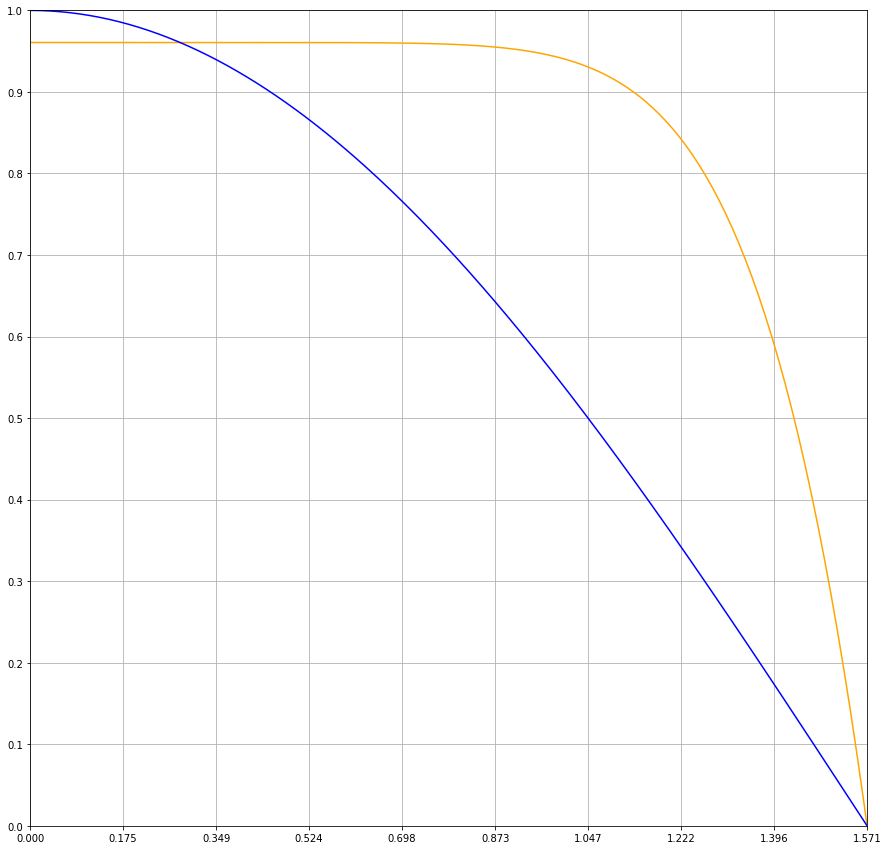

In [7]:
# i think the cos term above is wrong.
# instead use Schlick's approximation for specular reflection at the lower and upper surfaces
# https://en.wikipedia.org/wiki/Schlick%27s_approximation
# first just look at what it looks like.


n_1 = 1
n_2 = 1.495
r_0 = ((n_1 - n_2)/(n_1 + n_2)) ** 2
r = r_0 + (1 - r_0) * (1 - np.cos(theta_rad)) ** 5

print(np.min(r)) # 0.03936

(fig,ax)=plt.subplots(figsize=[15,15])
plt.plot(theta_rad, 1-r, color='orange', snap = False)
plt.plot(theta_rad, np.cos(theta_rad), color='blue', snap = False)

ax.xaxis.set_major_locator(ticker.LinearLocator(10))
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_xlim(0,np.pi/2)
ax.set_ylim(0,1)
plt.grid(True)

plt.show()

incident alive 20000000
surviving incident (remove entry reflected) 19213153 or 0.96066
confirm histogram sum 0.96066
count alive internal (remove absorbed) 17649640 or 0.88248
confirm histogram sum 0.88248
count alive external (remove exit reflected) 16799859 or 0.83999
confirm histogram sum 0.83999
max 0.8389481825212683


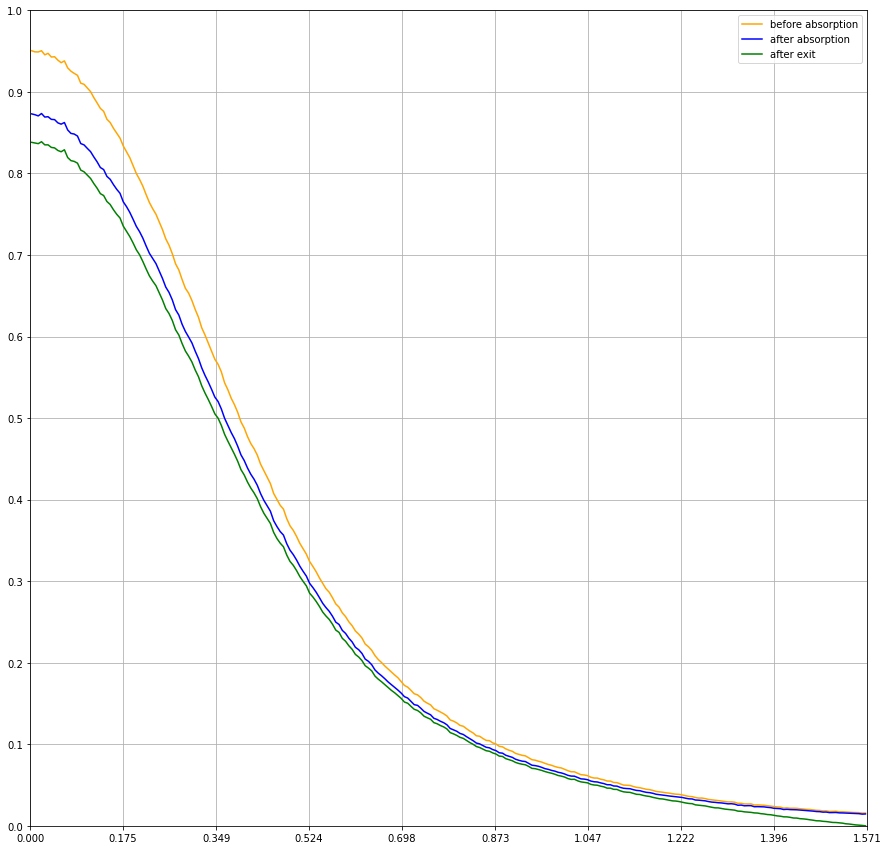

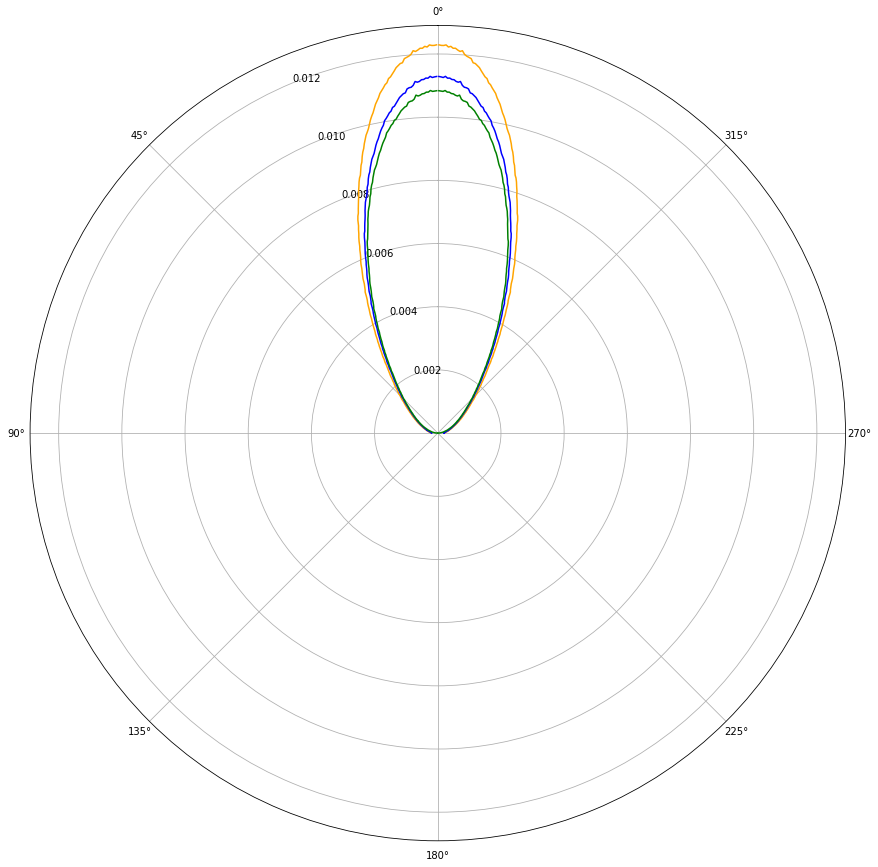

In [8]:
# so now try again with this function.  want total transmission to be 84%, fwhm 40 degrees

def r(theta_rad):
    n_1 = 1
    n_2 = 1.495
    r_0 = ((n_1 - n_2)/(n_1 + n_2)) ** 2
    r = r_0 + (1 - r_0) * (1 - np.cos(theta_rad)) ** 5
    return r

# try the library version
import scattering

scat = scattering.AcryliteScattering()
size = 20000000
alive = cp.ones(size, dtype=bool)
print(f"incident alive {cp.sum(alive)}")
      
# reflect at the incident surface, theta = zero, R = 0.03936
alive = cp.logical_and(alive, cp.random.rand(size) < (1 - 0.03936))
print(f"surviving incident (remove entry reflected) {cp.sum(alive)} or {cp.sum(alive)/size:.5f}")

# scatter

samples = scat.get_scattering_theta(size) # "samples" contains thetas

h, b = cp.histogram(samples, bins, weights=alive)
h =  h / size
print(f"confirm histogram sum {np.sum(h):.5f}")

# absorption
epsilon = 0.0814
alive = cp.logical_and(alive, cp.random.rand(size) > epsilon)
print(f"count alive internal (remove absorbed) {cp.sum(alive)} or {cp.sum(alive)/size:.5f}")
h2, b2 = cp.histogram(samples, bins, weights=alive)
h2 =  h2 / size
print(f"confirm histogram sum {np.sum(h2):.5f}")

# reflect at the exit surface
#alive = cp.logical_and(alive, cp.random.rand(size) < cp.cos(samples))
alive = cp.logical_and(alive, cp.random.rand(size) < (1 - r(samples)))
print(f"count alive external (remove exit reflected) {cp.sum(alive)} or {cp.sum(alive)/size:.5f}")

h3, b3 = cp.histogram(samples, bins, weights=alive)
h3 =  h3 / size
print(f"confirm histogram sum {np.sum(h3):.5f}")


(fig,ax)=plt.subplots(figsize=[15,15])
#scaling = 0.01312 # put the max at 0.84 to see the FWHM
scaling = 0.01293 # put the max at 0.84 to see the FWHM
print(f"max {cp.max(h3).get()/scaling}")
plt.plot((b.get()[:-1]+ b.get()[1:])/2, h.get() / scaling, color='orange', label='before absorption', snap = False)
plt.plot((b2.get()[:-1]+ b2.get()[1:])/2, h2.get() / scaling, color='blue', label='after absorption', snap = False)
plt.plot((b3.get()[:-1]+ b3.get()[1:])/2, h3.get() / scaling, color='green', label='after exit', snap = False)

ax.xaxis.set_major_locator(ticker.LinearLocator(10))
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_xlim(0,np.pi/2)
#ax.set_ylim(0,0.012)
ax.set_ylim(0,1)
plt.grid(True)
plt.legend()
plt.show()

fig = plt.figure(figsize=[15,15])
axes = plt.subplot(projection="polar")
axes.set_theta_zero_location("N")
axes.set_theta_zero_location("N")
axes.plot((b.get()[:-1]+ b.get()[1:])/2, h.get(), color="orange", snap=False)
axes.plot(-(b.get()[:-1]+ b.get()[1:])/2, h.get(), color="orange", snap=False)
axes.plot((b2.get()[:-1]+ b2.get()[1:])/2, h2.get(), color="blue", snap=False)
axes.plot(-(b2.get()[:-1]+ b2.get()[1:])/2, h2.get(), color="blue", snap=False)
axes.plot((b3.get()[:-1]+ b3.get()[1:])/2, h3.get(), color="green", snap=False)
axes.plot(-(b3.get()[:-1]+ b3.get()[1:])/2, h3.get(), color="green", snap=False)

plt.show()